# WIN Hackathon 2 - Computational modelling of behaviour - Part 2

**Developers**

Jan Grohn (jan.grohn@psy.ox.ac.uk), Miriam Klein-Flügge (miriam.klein-flugge@psy.ox.ac.uk)  


# Introduction
**Aims for part 2:**
- Develop the computational model further to include both learning and decision-making
- Understand how you can validate your model using simulations


## Import libraries

In [ ]:
# check if we are running on colab
try:
    from google.colab import files
    _ON_COLAB = True
except:
    _ON_COLAB = False

if _ON_COLAB:
    # this allows us to make interactive figures
    from google.colab import output
    output.enable_custom_widget_manager()

    # load in some custom functions for this hackathon
    !rm -r *
    !git clone -b winhack https://github.com/jangrohn/ComputationalModelingBlockPractical
    !cp -R ComputationalModelingBlockPractical/part2/ part2
    !rm -rf ComputationalModelingBlockPractical

    %pip install -r ./part2/requirements.txt    

import numpy as np
import pandas as pd
rng = np.random.default_rng(12345)
from part2 import run_paramterer_recovery, plot_schedule, visualise_utility_function, visualise_softmax, plot_interactive_RL_model, plot_likelihood_landscapes, plot_recovered_parameters

## Generate and plot a schedule

In [ ]:
def generate_schedule(trueProbability, rng = rng):
  '''
  Returns if option 1 (True) or option 2 (False) is rewarded on a trial, and the
  reward magnitudes on that trial.

    Parameters:
        trueProbability(float array): The probability with which option 1 is
          rewareded on each trial

    Returns:
        opt1rewarded(int array): 1 if option 1 is rewarded on a trial, 0 if
          option 2 is rewarded on a trial
        magOpt1(int array): reward points between 1 and 100 for option 1 on each
          trial
        magOpt2(int array): reward points between 1 and 100 for option 2 on each
           trial
  '''
  # We'll simulate whether opt 1 was rewarded on every trial. For each trial, we
  # generate a random number between 0 and 1. The trial is rewarded if that
  # number is smaller than trueProbability, and unrewarded otherwise.
  # The reward magnitudes are integers between 1 and 100.
  opt1Rewarded = (rng.random(len(trueProbability)) < trueProbability).astype(int)
  magOpt1 = rng.integers(1,101,len(trueProbability))
  magOpt2 = rng.integers(1,101,len(trueProbability))
  return opt1Rewarded, magOpt1, magOpt2


# true underlying reward probabilites on each trial
trueProbability = np.concatenate((np.ones(100, dtype = float)*0.75,
                                  np.ones(25,  dtype = float)*0.25,
                                  np.ones(25,  dtype = float)*0.75,
                                  np.ones(25,  dtype = float)*0.25,
                                  np.ones(25,  dtype = float)*0.75))

# generate a schedule
opt1Rewarded, magOpt1, magOpt2 = generate_schedule(trueProbability)

# plot it
plot_schedule(opt1Rewarded, trueProbability, magOpt1, magOpt2)

In [ ]:
# define the utility function as per equation 3
def multiplicative_utility(mag, prob):
  return mag*prob

visualise_utility_function(multiplicative_utility)

In [ ]:
# additive utility function as per equation 4
def additive_utility(mag, prob, omega):
  return (omega*(mag/100) + (1-omega)*prob)*100

visualise_utility_function(additive_utility, omega = True)

# Section 1: Expanding the computational model – making decisions

As outlined in part 1, the reinforcement learning model combined with a utility function generates utility (or value) for each option. The model should prefer the option with the higher utility, but how can we make it select a specific option on each trial? Intuitively, you might want to say, always pick the option with the higher utility even if the difference is small. This would be a deterministic decision rule and given our current task would be the optimal choice strategy. However, we know that this is not how real participants behave; they behave stochastically, i.e., they sometimes make mistakes and instead pick options with lower value. This is particularly pronounced when the two options’ utilities are similar, i.e., when the decision is more difficult.

Why do you think that in the current scenario it is always best to pick the option with the higher utility? And, given your answer, can you think of another scenario in which a better strategy would be to sometimes choose the alternative option?


The figure below illustrates the difference between a deterministic (red) and a stochastic (black) decision rule.

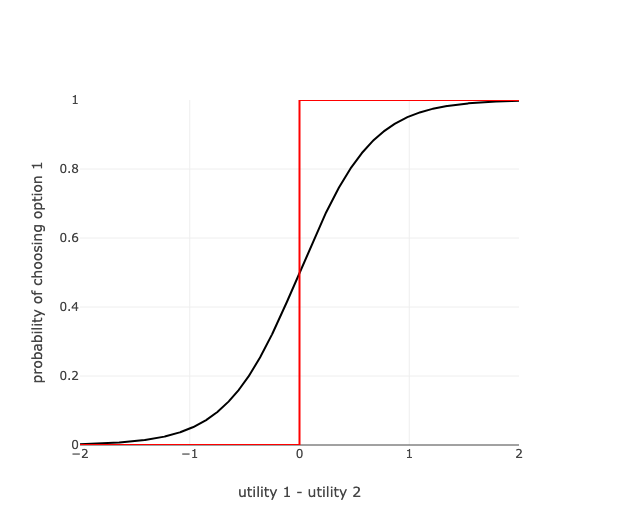

Can you describe what you see in the figure?

### The softmax function

A mathematical function that produces this shape of the
stochastic decision rule is the 'logistic function'; it is also
called a ‘softmax decision rule’ or a 'sigmoid function':

$$
\underbrace{P(c_1)}_\textrm{probability of choosing option 1} = \frac{e^{\beta u_1}}{e^{\beta u_1} + e^{\beta u_2}} = \frac{1}{1+ e^{-\beta(u_1 - u_2)}} \tag{Equation 7}
$$

Here, $u_1$ is the utility associated with option 1, and $u_2$ the utility of option 2. $\beta$ is a free parameter, also
called the 'inverse temperature'. The higher the inverse
temperature, the 'steeper' the softmax is (i.e., the less
stochastic). The reason it is called 'inverse temperature' is an allusion to thermodynamics: you can think of it as the higher the temperature (i.e. the lower the inverse temperature), the faster particles move around, i.e., the more noise there is or the more stochastic behavior becomes.

Complete the softmax function in the next code cell as shown in equation 5. Hint: the $e$ function is implemented in python as `np.exp()`. When you have completed the function, run the cell. It should produce a plot similar to the one pictured above.   

In [ ]:
# softmax function as per equation 7
def softmax(utility1, utility2, beta):
  return np.exp(utility1*beta)/(np.exp(utility1*beta) + np.exp(utility2*beta))

visualise_softmax(softmax)


To have a look at what the effect of changing the inverse temperature is, change the beta slider to different values. What do you notice as you change the inverse temperature?

### Using utility and the softmax function with the RL model

We can now extend the script which we wrote during the last part to simulate an RL model such that it also combines reward magnitudes and probabilities using a utility function. The script then compares the utility of both options using a softmax function to calculate the probability of choosing option 1 for each trial.

Run the next code cell to simulate the RL model. In the resulting plot, you can change the values of $\alpha$ and $\beta$ to see how it affects the model predictions. If the plot gets too busy and you want to focus on particular elements of the model, you can switch on and off what is being displayed by clicking on the corresponding legend entries.

### Simulating and visualising the RL model with multiplicative utility

In [ ]:
def simulate_RL_model(opt1Rewarded,
                      magOpt1,
                      magOpt2,
                      alpha,
                      beta,
                      *additonalParameters,
                      startingProb = 0.5,
                      utility_function = multiplicative_utility,
                      choice_function = softmax):
  '''
  Returns how likely option 1 is rewarded on each trial, the probability of
  choosing option 1 on a trial, and a simulated choice for each trial

    Parameters:
        opt1rewarded(bool array): True if option 1 is rewarded on a trial, False
          if option 2 is rewarded on a trial.
        magOpt1(int array): reward points between 1 and 100 for option 1 on each
          trial
        magOpt2(int array): reward points between 1 and 100 for option 2 on each
           trial
        alpha(float): fixed learning rate, greater than 0, less than/equal to 1
        beta(float): fixed inverse temperature, greater than 0
        *additionalParameters(float, optional): other parameters to pass onto
          the utility function, for example, the omega used in additive utility.
        startingProb(float): starting probability (defaults to 0.5).
        utility_function(function): what utility function to use to combine
          reward magnitude and probability. Defaults to multiplicative_utility
        choice_function(function): what choice function to use to decide
          between utility1 and utility2. Has free parameter beta. Defaults
          to softmax.

    Returns:
        probOpt1(float array): how likely option 1 is rewarded on each trial
          according to the RL model.
        choiceProb1(float array): the probability of choosing option 1 on each
          trial when combining information about magnitude and probability
  '''

  # check that alpha has been set appropriately
  assert alpha > 0, 'Learning rate (alpha) must be greater than 0'
  assert alpha <= 1,'Learning rate (alpha) must be less than or equal to 1'

  # check that inverse temperateure has been set appropriately
  assert beta >= 0, 'beta must be greater or equal than 0'

  # check that startingProb has been set appropriately
  assert startingProb >= 0, 'startingProb must be greater or equal than 0'
  assert startingProb <= 1, 'startingProb must be less than or equal to 1'

  # calculate the number of trials
  nTrials = len(opt1Rewarded)

  # pre-create some vectors we're going to assign into
  probOpt1    = np.zeros(nTrials, dtype = float)
  delta       = np.zeros(nTrials, dtype = float)
  choiceProb1 = np.zeros(nTrials, dtype = float)

  # set the first trial's prediction to be equal to the starting probability
  probOpt1[0] = startingProb

  for t in range(nTrials-1):
        # calculate the utility of the two options. *additionalParameters would only be needed
        # if the utility function has >2 inputs, which is not the case for multiplicative
        # utility.
        utility1 = utility_function(magOpt1[t], probOpt1[t], *additonalParameters)
        utility2 = utility_function(magOpt2[t], (1 - probOpt1[t]), *additonalParameters)

        # get the probability of making choice 1
        choiceProb1[t] = choice_function(utility1, utility2, beta)

        # calculate the prediction error
        delta[t] = opt1Rewarded[t] - probOpt1[t]

        # update the probability of option 1 being rewarded
        probOpt1[t+1] = probOpt1[t] + alpha*delta[t]

  return probOpt1, choiceProb1

# visualise the simulated RL model
plot_interactive_RL_model(simulate_RL_model, multiplicative_utility, opt1Rewarded, magOpt1, magOpt2, trueProbability)

As you change $\alpha$ and $\beta$, what do you notice about the choice probability? Why is it different from the reward predictions? Both in terms of that it can reach up to 1, rather than plateauing at about 0.8 and that sometimes predictions can be high (i.e., the model believes that it is
likely that the reward will be behind option A), but choice probability is low (i.e., the model is more likely to choose option 2)? If the plot is too crowded, you can switch off elements by clicking on the corresponding entry in the legend on the right.

Next, we make the same plot but assuming an additive utility function. Run the next code cell now and again change the parameters. Why does the utility function take on the shape it does as you change $\omega$ to the extremes of 0 and 1? What does this mean for the choice probabilities? And how does $\omega$ interact with $\alpha$ and $\beta$? Again, if the plot is too crowded you can temporarily switch off elements by clicking on the corresponding entry in the legend on the right.

### Simulating and visualising the RL model with additive utility

In [ ]:
plot_interactive_RL_model(simulate_RL_model, additive_utility, opt1Rewarded, magOpt1, magOpt2, trueProbability, omega = True)

The model's choice probabilities are crucial for fitting the model to the data and for making simulations (next section in this part). In short, when fitting a model we ask, given a participant's choices, what their model parameters must have been to produce
these choices. Python does this by changing the model parameters (here learning rate $\alpha$, inverse temperature $\beta$, and optionally $\omega$ for additive utility) until the choice probabilities match participant's actual choices as closely as possible.

# Section 2: Parameter recovery

## Creating simulations from the model

You now know all the key equations that define our computational model. We will use the model to simulate data (if you are interested in fitting data from real participants, you can look at our block practical session 3 [here](https://github.com/JanGrohn/ComputationalModelingBlockPractical). This involves the following steps:


1. give your computational model the same sequence of trials that you want to give to your real participants (in our case, the outcomes [reward behind option 1 or option 2] and the reward
magnitudes)
2. pick values for the parameters (i.e., for the learning rates for the stable and the volatile block)
3. use the model with those chosen parameters to simulate choices (i.e., meaning that you know the ground truth that we don’t know for real participants)
4. use the same analysis technique you want to use for the real data to analyse the simulated choices (i.e., fit a reinforcement learning model to obtain 'fitted parameters').
5. compare the fitted to the simulated parameters (i.e., they should be more or less the same, but see below for why this might not be the case)

Why is it so important for you to run simulations rather than just fitting your model to the data? You can use the simulations to validate your experiment and your analysis method. For example, you might find that the fitted parameters are very different from the simulated parameters. This tells you that there is a serious problem with either how you have designed your experiment or your analysis approach. For example, it could be that you have not included enough trials in your experiment; or it could be that you have made a coding error somewhere and accidentally always presented the higher reward magnitude on top of the option that also had the higher probability; or it could be that the
range of reward magnitudes and probabilities you picked is inappropriate (e.g., imagine that the probabilities were too close to 50% and that participants only use the reward magnitudes to guide their choices).

For the possibilities described above, can you imagine why this might lead to the fitted parameters not matching the ones used to simulate the choices?

Can you think of how you could plot the fitted and the simulated parameters to check whether they are similar? And what kind of statistical measure would you use to quantify their 'similarity'?

The second way in which you would want to use simulations is to check that your experiment is capable of confirming or disconfirming your experimental hypothesis.

How would you simulate data to check that the model is capable of testing our hypothesis that learning rates are lower in the stable than the volatile block? Hint: you will need to simulate data for two possibilities.

## Model simulations

We have now almost completed all steps to create simulations: we have generated a schedule (last part), we have used a model with parameter values of our choosing (for learning rate and inverse temperature) to create choice probabilities. We now need to translate them into actual choices. In other words, for each trial, we now have a probability that the model (i.e.,
simulated participant) should choose option A over B; however, in our actual task, on each trial participants need to then translate this choice probability into pressing a single button. For the simulations we will run for the remainder of this part, we will assume that our simulated participants use multiplicative utility.

To generate random choices from the model, we will use a procedure similar to how translated a reward probability into an actual reward outcome when making a schedule in part 1. That is, we will use the `rng.random()` function, which generates a random number between 0 and 1, and compare this random number against a choice probability. For example, assume the choice probability on a trial is 0.8. If we do a comparison such as shown in the next code cell, then this comparison should, by chance, give you the value of 'true' in 80% of cases, and 'false' in 20% of cases. You can verify this by running the code cell repeatedly.



In [ ]:
0.8 > rng.random()

Using this logic, complete the code below and then run it. You should obtain an updated version of the previous figure that now also plots the simulated choices. Again, if the figure is too crowded, you can hide elements by clicking on the corresponding entry in the figure legend. What do you notice about the relationship between choice probability (red) and the actual choices?

In [ ]:
# set parameters for the simulation
alpha = 0.3
beta  = 0.05

# run the RL model
probOpt1, choiceProb1 = simulate_RL_model(opt1Rewarded, magOpt1, magOpt2, alpha, beta)

nTrials = len(probOpt1)

# simulate a choice according to the probability
choice1 = np.zeros(nTrials, dtype = int)
for t in range(nTrials):
  choice1[t] = choiceProb1[t] > rng.random()

# plot the model output
plot_schedule(opt1Rewarded, trueProbability, magOpt1, magOpt2, probOpt1, choiceProb1, choice1)

To help you relate what we have looked at so far to data from our real participant, think about which line in the figure above is directly measured from a real participant? And which ones can we get only as latent parameters from our model?

## Fitting models using maximum likelihood


### The likelihood function

Given choice data, we can ask which model parameters best describe these choices. To do this, we need to estimate the *likelihood* of the choices being produced from a model with specific parameter values. In our case, the trial-by-trial likelihood is directly given by the softmax function of the utilities associated with both options on that trial (i.e. the choice probability). Thus, to calculate the likelihood for given values of $\alpha$ and $\beta$, we need to calculate the choice probability for each trial and compare whether this matches the actual choices a (simulated) participant made. If the choice probability is close to the actual choice, the likelihood is high, and if the choice probbility is far from the actual choice, then the likelihood low.

In other words, if you were to move the sliders for the model parameters $\alpha$ and $\beta$ around until the choice probability is as close to the choices as possible, then you would try to find the model with the highest likelihood.

The next code cell simulates a synthetic dataset and then tries to recover the values of $\alpha$ and $\beta$ that were used for the simulation. To do so, the script tries out a range of $\alpha$ and $\beta$ values in a grid, and computes the likelihood for each $\alpha$, $\beta$ pair. This way of trying to find the parameters with the highest likelihood is called a 'grid search'.

Run the next code cell now. This might take a bit as a grid search needs to try out many different parameter values. The two plots that the code produces are the likelihood and log likelihood landscapes for different values of $\alpha$ and $\beta$. The aim of maximum liklihood estimation is to find the peak of these landscapes. Just as with previous 3d plots, you can rotate the figures by holding and dragging your cursor. 

In [ ]:
# set the true parameters for the simulation
alpha = 0.3
beta  = 0.2

# simulate a schedule
opt1Rewarded, magOpt1, magOpt2 = generate_schedule(trueProbability)

# get the RL model estimates
probOpt1, choiceProb1 = simulate_RL_model(opt1Rewarded, magOpt1, magOpt2, alpha, beta)

# simulate random choices based on the model output
choice1 = (choiceProb1 > rng.random(nTrials)).astype(int)

# calculate and plot the likelihood for a range of alpha and beta pairs
plot_likelihood_landscapes(opt1Rewarded, magOpt1, magOpt2, choice1)

Describe what the likelihood landscape tells us about the recovered values of $\alpha$ and $\beta$. Can the landscape also be used to inform us about the uncertainty in our estimates of $\alpha$ and $\beta$?

## Running a parameter recovery

Now that we understand how in a simulation choice probabilities are translated into actual choices, and how we can estimate the paramters underlying (simulated) data, let's return to using simulations to check that our task and analysis methods are appropriate.

The next code cell runs simulations (i.e., it generates 'actual choices') for a range of learning rates (alphas) and choice stochasticity values (inverse temperatures; beta). The code uses the model that we've developed above. How could you decide what ranges of learning rates and inverse temperatures to use for the simulations?

The script then fits the simulated choices to obtain 'fitted parameters'. Look at the figures that are produced by running the next code cell.

#### Simulating choices and recovering parameters

In [ ]:
# the parameter ranges we want to simulate from
simulatedAlphaRange = np.arange(0.01, 0.7, 0.05)
simulatedBetaRange  = np.arange(0.01, 0.4, 0.05)

# run the parameter recovery
recoveryData = run_paramterer_recovery(
    simulatedAlphaRange, # what alpha values to try out
    simulatedBetaRange,  # what beta values to try out
    simulate_RL_model,   # the function we use to simulate the RL model
    generate_schedule,   # the function we use to generate a schedule
    trueProbability,     # the reward probabilities the schedule is generated from
    rng,                 # the random number generator we use
    )

plot_recovered_parameters(recoveryData)

This figure shows correlations between simulated and fitted parameters. What do you observe and does it suggest that our task has a problem or not?

To better understand why the recovery of the learning rates had some strange outlier values, you can hover over simulated and recoverd alpha values to see the corresponding inverse temperature. How do you interpret what you find and what does it mean for analyzing our real participants' data? Would you be satisfied with the recovery or concerned for going ahead with an experiment in real participants? This process that involves simulating and fitting simulated data is important for experimantal design and has become a standard way to design experiments and analyses in computational cognitive neuroscience. 

The strength of using models like the one we learned about today is that they allow us to understand latent causes of behaviour that are not accessible with simpler analyses. Capturing such latent processes has led to important discoveries about the brain mechanism underlying these behaviours. For example, the trial-wise prediction errors that our model generates can be used as a parametric regressor in a FEAT GLM and will show beautiful BOLD correlates in the dopaminergic system, including the ventral striatum.  